Non-maxima suppression (NMS)
- We have a set of overlapping boxes predicting the same object
- NMS keeps the *best* box and removes other boxes that have high overlap with it
1. Sort boxes by descending score
2. Pick the highest-scoring box
3. Remove all remaining boxes that overlap with the kept box above a threshold
4. Repeat with the remaining boxes
- We get a filtered list of boxes

Format
- `[x1, y1, x2, y2]`
- `(x1, y1)` = top-left corner
- `(x2, y2)` = bottom-right corner
- assume that `x2 >= x1`, `y2 >= y1`

Intersection over Union (IoU) computed as:
$$
\text{IoU} = \frac{\operatorname{area}(A \cap B)}{\operatorname{area}(A \cup B)}
$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [3]:
def iou_vectorized(box: np.ndarray, boxes: np.ndarray) -> np.ndarray:
    """
    Compute the IoU between a single box and an array of boxes.
    box: shape (4,) -> [x1, y1, x2, y2]
    boxes: shape (N, 4)
    returns: ious shape (N,)
    """
    # intersection coordinates
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])
    
    # intersection area
    inter_w = np.maximum(0.0, x2 - x1)
    inter_h = np.maximum(0.0, y2 - y1)
    inter_area = inter_w * inter_h

    # area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # union
    union_area = box_area + boxes_area - inter_area

    # avoid division by zero
    ious = inter_area / (union_area + 1e-12)
    return ious


In [4]:
def nms_numpy(boxes: np.ndarray, scores: np.ndarray, iou_threshold: float) -> List[int]:
    """
    Non-Maximum Suppression (NMS)
    boxes: (N,4) array of [x1,y1,x2,y2]
    scores: (N,) confidence scores
    iou_threshold: IoU threshold above which boxes are suppressed
    returns: list of indices of boxes to keep (in descending-score order)
    """
    if len(boxes) == 0:
        return []

    # Convert to float for computations
    boxes = boxes.astype(np.float32)
    scores = scores.astype(np.float32)

    # sort by scores descending
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(int(i))

        if order.size == 1:
            break

        rest = order[1:]
        ious = iou_vectorized(boxes[i], boxes[rest])

        # keep only indices where IoU <= threshold
        inds_to_keep = np.where(ious <= iou_threshold)[0]

        # map back to original order indices; +1 because rest = order[1:]
        order = order[np.concatenate(([0], inds_to_keep + 1))]  # keep current + filtered rest
        # now drop the current (we already appended it), so slice from 1
        order = order[1:]

    return keep



In [5]:
# Cell: wrapper returning filtered boxes
def nms_filter(boxes, scores, iou_threshold=0.5):
    """
    Convenience: returns (kept_boxes, kept_scores, kept_indices)
    """
    boxes = np.asarray(boxes)
    scores = np.asarray(scores)
    keep_idx = nms_numpy(boxes, scores, iou_threshold)
    kept_boxes = boxes[keep_idx]
    kept_scores = scores[keep_idx]
    return kept_boxes, kept_scores, keep_idx


Tests + visualization

In [6]:
# Cell: sample boxes and scores
boxes = np.array([
    [10, 10, 50, 50],
    [12, 12, 52, 52],  # overlaps strongly with box 0
    [100, 100, 140, 140],
    [105, 105, 145, 145], # overlaps with box 2
    [200, 200, 240, 240], # isolated
    [11, 11, 49, 49],     # another overlapping with 0/1
], dtype=np.float32)

scores = np.array([0.9, 0.8, 0.7, 0.6, 0.95, 0.85], dtype=np.float32)

kept_boxes, kept_scores, kept_idx = nms_filter(boxes, scores, iou_threshold=0.5)
print("Kept indices:", kept_idx)
print("Kept boxes:\n", kept_boxes)
print("Kept scores:\n", kept_scores)


Kept indices: [4, 0, 2]
Kept boxes:
 [[200. 200. 240. 240.]
 [ 10.  10.  50.  50.]
 [100. 100. 140. 140.]]
Kept scores:
 [0.95 0.9  0.7 ]


Visualize before / after

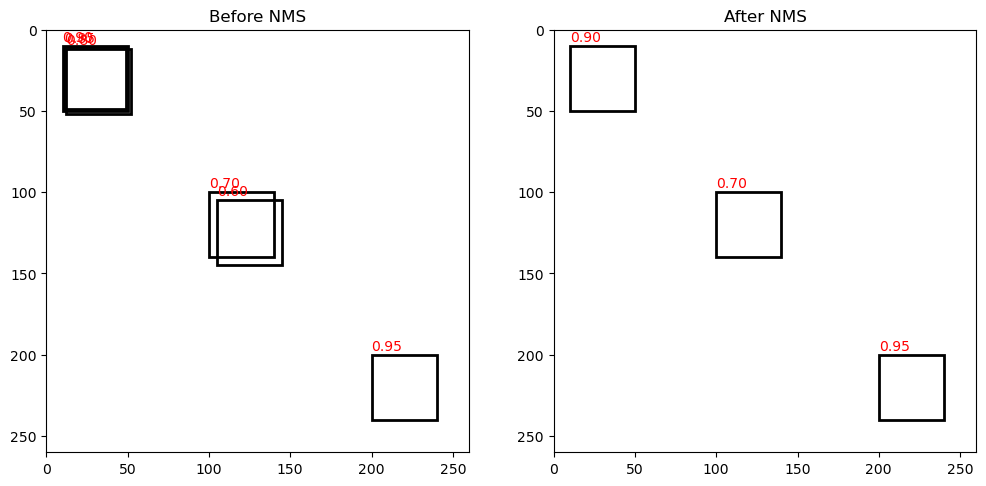

In [7]:
# Cell: visualization function
def plot_boxes(boxes, scores=None, title="Boxes", ax=None, colors=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6,6))
    else:
        fig = None
    ax.set_xlim(0, 260)
    ax.set_ylim(260, 0)  # invert y for image-like coords
    ax.set_title(title)
    ax.set_aspect('equal')
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, fill=False, linewidth=2)
        ax.add_patch(rect)
        label = f"{scores[i]:.2f}" if scores is not None else str(i)
        ax.text(x1, y1-3, label, fontsize=10, color='red')
    if fig is not None:
        plt.show()

# Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plot_boxes(boxes, scores, title="Before NMS", ax=axes[0])
plot_boxes(kept_boxes, kept_scores, title="After NMS", ax=axes[1])
plt.show()


Complexity
- Time: naive NMS is $O(N^2)$ in the worst case (computing IoU between remaining boxes repeatedly). Sorting adds $O(N \log N)$
- Memory: $O(N)$
- Class-aware NMS: if we have multi-class predictions, run NMS per class